In [1]:
import os
from os import path
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

import collections

import utils

# import logging as log
# log.basicConfig(level=log.DEBUG)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

In [2]:
DATA_FOLDER = path.join('..', 'data')
RESULTS_FOLDER = path.join('..', 'results')

STATES = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
         'DF', 'ES', 'GO', 'MA', 'MT', 'MS',
         'MG', 'PA', 'PB', 'PR', 'PE', 'PI',
         'RJ', 'RN', 'RO', 'RS', 'RR', 'SC',
         'SE', 'SP', 'TO']

MODELS = ['linear-regression', 'gaussian-process', 'mlp', 'svr', 'exponential-holt']

STRATEGIES = [
    'aggregated',
    'windowed'
]

METRICS = ['MAE', 'RMSE', 'MSLE']

# Load results

In [3]:
df_results_agg = pd.read_csv(path.join(RESULTS_FOLDER, 'results-aggregated.csv'), index_col=0)
df_results_agg.head()

,state,model,metric,yhat_model_1_to_7,yhat_model_1_to_8,yhat_model_1_to_9,yhat_model_1_to_10,yhat_model_1_to_11,yhat_model_1_to_12,yhat_model_1_to_13,...,yhat_model_1_to_52,yhat_model_1_to_53,yhat_model_1_to_54,yhat_model_1_to_55,yhat_model_1_to_56,yhat_model_1_to_57,yhat_model_1_to_58,yhat_model_1_to_59,yhat_model_1_to_60,yhat_model_1_to_61
0,AC,linear-regression,MAE,5.142857,5.671429,4.376667,3.717818,8.189333,7.825874,9.117216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AC,linear-regression,RMSE,6.061252,6.727641,5.474591,4.349823,9.245433,8.824073,9.825322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AC,linear-regression,MSLE,0.016516,0.019184,0.012799,0.006493,0.025928,0.021202,0.025726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AC,gaussian-process,MAE,17.453821,19.399558,22.624428,15.257678,12.842851,16.317758,18.761345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AC,gaussian-process,RMSE,20.098141,22.073480,25.305447,19.105770,18.690582,23.408477,26.532628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Create a pipeline for preprocessing

### 1. Select a state

In [4]:
def get_state(df, state='CE'):
    return df.loc[df.state == state]

### 2. Remove NaN columns. It means there is no data in theses days



In [5]:
def clean(df):
    return df.dropna(axis=1)

df = clean(get_state(df_results_agg, 'SP'))
df

,state,model,metric,yhat_model_1_to_7,yhat_model_1_to_8,yhat_model_1_to_9,yhat_model_1_to_10,yhat_model_1_to_11,yhat_model_1_to_12,yhat_model_1_to_13,...,yhat_model_1_to_32,yhat_model_1_to_33,yhat_model_1_to_34,yhat_model_1_to_35,yhat_model_1_to_36,yhat_model_1_to_37,yhat_model_1_to_38,yhat_model_1_to_39,yhat_model_1_to_40,yhat_model_1_to_41
375,SP,linear-regression,MAE,59.971429,75.079683,95.270519,120.114909,156.765333,204.057327,253.186081,...,3215.746031,3621.475542,3179.884127,2998.204265,2943.312112,2930.213634,3153.095291,3574.783460,3912.275345,3656.965470
376,SP,linear-regression,RMSE,92.030600,114.451209,147.408336,182.319939,236.709658,299.198348,357.825773,...,3891.255697,4224.773134,3792.045437,3673.173553,3658.268801,3715.507372,3937.532592,4362.132110,4666.897972,4428.821473
377,SP,linear-regression,MSLE,4.420683,3.606723,2.954053,2.819754,2.942582,3.537275,3.869458,...,1.003365,1.094031,0.563922,0.383989,0.302150,0.248234,0.232895,0.261409,0.272795,0.198805
378,SP,gaussian-process,MAE,61.244505,76.920205,98.772242,125.744587,163.830031,212.775352,261.697150,...,3510.208727,3905.177604,3495.008686,3522.784092,3473.877616,3573.915549,3809.336860,4319.158374,4676.406441,4489.093053
379,SP,gaussian-process,RMSE,93.450289,116.407418,151.040018,188.270508,244.416042,308.702236,367.541755,...,4224.674713,4545.909060,4145.990280,4223.018885,4223.988449,4401.017328,4689.134664,5190.656661,5504.382932,5337.553417
380,SP,gaussian-process,MSLE,5.704673,4.568730,3.989801,4.090876,4.299371,5.343415,5.422118,...,1.432169,1.489838,0.770484,0.610956,0.475035,0.417333,0.395922,0.445697,0.449812,0.341178
381,SP,mlp,MAE,58.828374,74.789991,95.634682,121.078559,157.510372,206.140906,255.865872,...,3324.493595,3716.653731,3276.780240,3111.830598,3078.986313,3126.303901,3371.069411,3774.371302,4081.814623,3819.793966
382,SP,mlp,RMSE,90.884719,114.117485,147.810518,183.411022,237.555287,301.595723,360.957379,...,4030.265248,4365.535437,3943.240496,3849.069601,3858.895064,3947.977565,4196.270777,4636.678626,4950.244714,4732.706180
383,SP,mlp,MSLE,3.676702,3.482107,3.043388,2.994886,3.052043,3.870287,4.266659,...,1.147068,1.233294,0.638592,0.442054,0.352893,0.295194,0.278894,0.309953,0.319910,0.236648
384,SP,svr,MAE,61.380339,77.045814,98.731120,125.434655,163.714807,212.455494,262.356841,...,3343.303920,3735.186727,3295.220780,3130.555285,3104.080977,3154.375947,3401.813566,3806.173485,4113.078347,3851.642384


### 3. Count days

In [6]:
def get_days(df, offset=7):
    return np.arange(offset, df.shape[1] - 3 + offset, 1)

get_days(df)

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41])

# Plot Figures

In [7]:
state = 'SP'
df_out = clean(get_state(df, state))
df_out

,state,model,metric,yhat_model_1_to_7,yhat_model_1_to_8,yhat_model_1_to_9,yhat_model_1_to_10,yhat_model_1_to_11,yhat_model_1_to_12,yhat_model_1_to_13,...,yhat_model_1_to_32,yhat_model_1_to_33,yhat_model_1_to_34,yhat_model_1_to_35,yhat_model_1_to_36,yhat_model_1_to_37,yhat_model_1_to_38,yhat_model_1_to_39,yhat_model_1_to_40,yhat_model_1_to_41
375,SP,linear-regression,MAE,59.971429,75.079683,95.270519,120.114909,156.765333,204.057327,253.186081,...,3215.746031,3621.475542,3179.884127,2998.204265,2943.312112,2930.213634,3153.095291,3574.783460,3912.275345,3656.965470
376,SP,linear-regression,RMSE,92.030600,114.451209,147.408336,182.319939,236.709658,299.198348,357.825773,...,3891.255697,4224.773134,3792.045437,3673.173553,3658.268801,3715.507372,3937.532592,4362.132110,4666.897972,4428.821473
377,SP,linear-regression,MSLE,4.420683,3.606723,2.954053,2.819754,2.942582,3.537275,3.869458,...,1.003365,1.094031,0.563922,0.383989,0.302150,0.248234,0.232895,0.261409,0.272795,0.198805
378,SP,gaussian-process,MAE,61.244505,76.920205,98.772242,125.744587,163.830031,212.775352,261.697150,...,3510.208727,3905.177604,3495.008686,3522.784092,3473.877616,3573.915549,3809.336860,4319.158374,4676.406441,4489.093053
379,SP,gaussian-process,RMSE,93.450289,116.407418,151.040018,188.270508,244.416042,308.702236,367.541755,...,4224.674713,4545.909060,4145.990280,4223.018885,4223.988449,4401.017328,4689.134664,5190.656661,5504.382932,5337.553417
380,SP,gaussian-process,MSLE,5.704673,4.568730,3.989801,4.090876,4.299371,5.343415,5.422118,...,1.432169,1.489838,0.770484,0.610956,0.475035,0.417333,0.395922,0.445697,0.449812,0.341178
381,SP,mlp,MAE,58.828374,74.789991,95.634682,121.078559,157.510372,206.140906,255.865872,...,3324.493595,3716.653731,3276.780240,3111.830598,3078.986313,3126.303901,3371.069411,3774.371302,4081.814623,3819.793966
382,SP,mlp,RMSE,90.884719,114.117485,147.810518,183.411022,237.555287,301.595723,360.957379,...,4030.265248,4365.535437,3943.240496,3849.069601,3858.895064,3947.977565,4196.270777,4636.678626,4950.244714,4732.706180
383,SP,mlp,MSLE,3.676702,3.482107,3.043388,2.994886,3.052043,3.870287,4.266659,...,1.147068,1.233294,0.638592,0.442054,0.352893,0.295194,0.278894,0.309953,0.319910,0.236648
384,SP,svr,MAE,61.380339,77.045814,98.731120,125.434655,163.714807,212.455494,262.356841,...,3343.303920,3735.186727,3295.220780,3130.555285,3104.080977,3154.375947,3401.813566,3806.173485,4113.078347,3851.642384


In [8]:
def get_data(df, state='CE'):
    df_out = clean(get_state(df, state))
    days = get_days(df_out)
    
    return df_out, days

## Freeze model, by metric

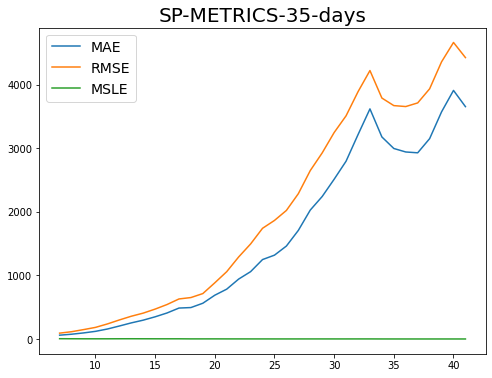

In [9]:
state = 'SP'
df, days = get_data(df_results_agg, state)

g = df.groupby(by=['model'])
x = g.get_group('linear-regression').drop(['state', 'model', 'metric'], axis=1)

plt.figure(figsize=(8,6))

for i in range(len(METRICS)):
    plt.plot(days, x.iloc[i].values, label=METRICS[i])
    
    plt.legend(fontsize=14)
    
plt.title(f'{state}-METRICS-{days.shape[0]}-days', fontsize=20)
plt.show()

## Freeze Metric, by model

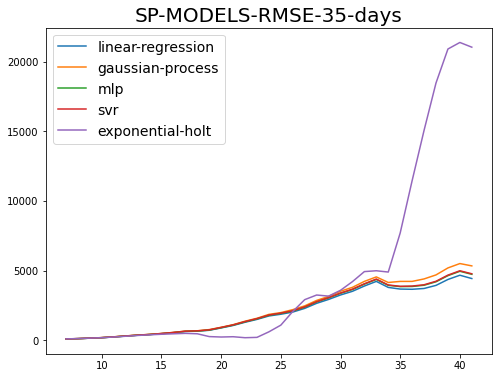

In [10]:
state = 'SP'
df, days = get_data(df_results_agg, state)

metric = 'RMSE'
g = df.groupby(by=['metric'])
x = g.get_group(metric).drop(['state', 'model', 'metric'], axis=1)

plt.figure(figsize=(8,6))

for i in range(x.shape[0]):
    plt.plot(days, x.iloc[i].values, label=MODELS[i])
    
    plt.legend(fontsize=14)
    
plt.title(f'{state}-MODELS-{metric}-{days.shape[0]}-days', fontsize=20)
plt.show()

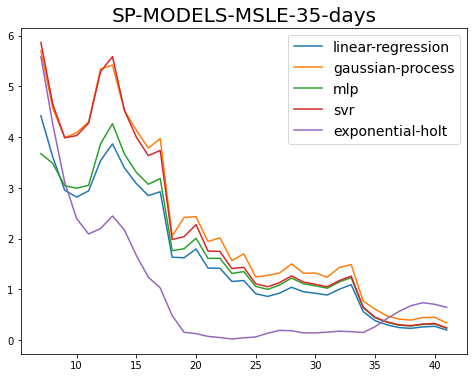

In [11]:
state = 'SP'
df, days = get_data(df_results_agg, state)

metric = 'MSLE'
g = df.groupby(by=['metric'])
x = g.get_group(metric).drop(['state', 'model', 'metric'], axis=1)

plt.figure(figsize=(8,6))

for i in range(x.shape[0]):
    plt.plot(days, x.iloc[i].values, label=MODELS[i])
    
    plt.legend(fontsize=14)
    
plt.title(f'{state}-MODELS-{metric}-{days.shape[0]}-days', fontsize=20)
plt.show()

## Freeze Metric and see state and model

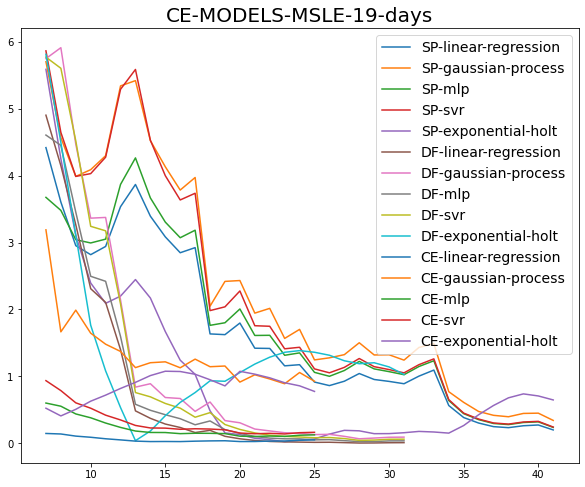

In [12]:
metric = 'MSLE'

plt.figure(figsize=(10,8))

STATES_2 = ['SP', 'DF', 'CE']

for state in STATES_2:
    df, days = get_data(df_results_agg, state)

    g = df.groupby(by=['metric', 'model'])
    for model in MODELS:
        x = g.get_group((metric, model)).drop(['state', 'model', 'metric'], axis=1)

        for i in range(x.shape[0]):
            plt.plot(days, x.iloc[i].values, label=f'{state}-{model}')

            plt.legend(fontsize=14)

    plt.title(f'{state}-MODELS-{metric}-{days.shape[0]}-days', fontsize=20)

plt.show()

# Generate Figure for each model in a each type of methodology

## Figure for the `aggregated` methodology

### metric = `MSLE`

linear-regression
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-linear-regression-MSLE.png


<Figure size 720x576 with 0 Axes>

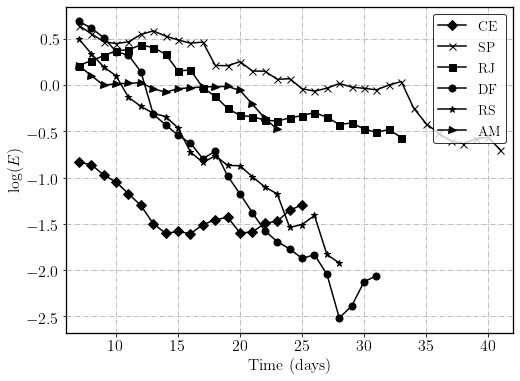

gaussian-process
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-gaussian-process-MSLE.png


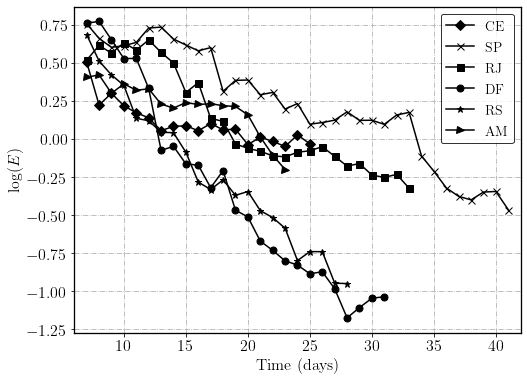

mlp
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-mlp-MSLE.png


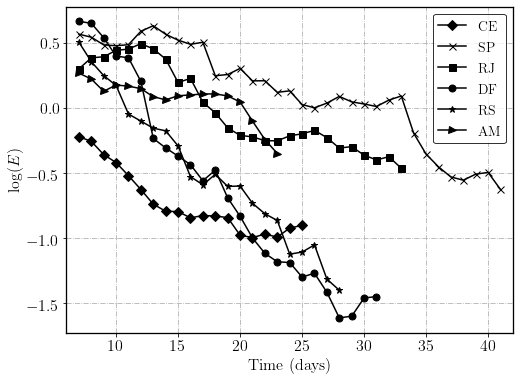

svr
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-svr-MSLE.png


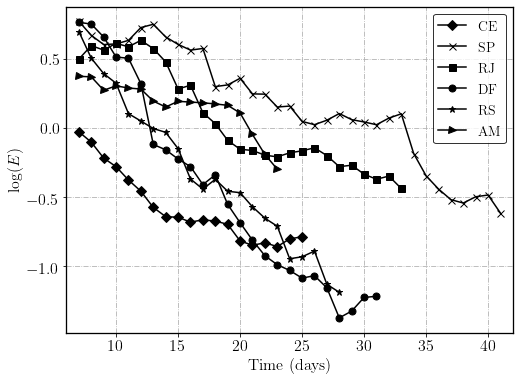

exponential-holt
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-exponential-holt-MSLE.png


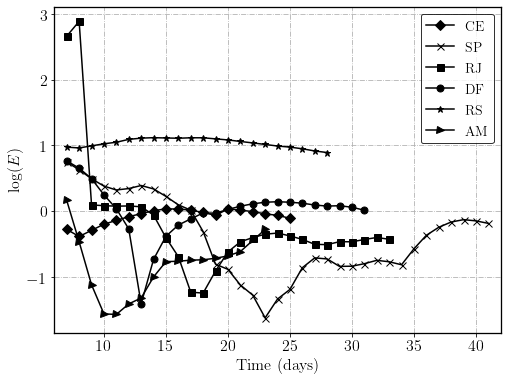

In [13]:
metric = 'MSLE'

plt.figure(figsize=(10,8))

FONTSIZE=16
STATES_2 = ['CE', 'SP', 'RJ', 'DF', 'RS', 'AM']
MARKERS = ['D', 'x', 's', 'o', '*', '>']

plt.rc('font', family='serif')
plt.rc('text', usetex=True)  

plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')



for model in MODELS:
    fig = plt.figure(figsize=(8, 6))
    print(model)
    id_state = 0
    for state in STATES_2:
        print(state)
        df, days = get_data(df_results_agg, state)

        g = df.groupby(by=['metric', 'model'])
    
        data = g.get_group((metric, model)).drop(['state', 'model', 'metric'], axis=1)

        ax = fig.add_subplot(1, 1, 1)

        x = days
        # Filter data
        y = data.iloc[i].values
        
        ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)
        
        id_state += 1

    # Set limits
    plt.xlim(6, 42)
    # plt.ylim(-0.5, 11)

    #
    for ori in ax.spines:
        ax.spines[ori].set_linewidth(1.3)

    #
    ax.set_ylabel('$\log(E)$', fontsize=FONTSIZE)
    ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
    
    plt.yticks(fontsize=FONTSIZE)
    plt.xticks(fontsize=FONTSIZE)
    
    leg = plt.legend(fontsize=FONTSIZE-2, loc='upper right')
    leg.get_frame().set_edgecolor('k')
    
    plt.grid(ls='-.')

    #
    filename = path.join(RESULTS_FOLDER, 'figures', f'aggregated-{model}-{metric}.png')
    print(filename)
    plt.savefig(filename, dpi=300)
    #
    plt.show()

### metric = `RMSE`

linear-regression
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-linear-regression-RMSE.png


<Figure size 720x576 with 0 Axes>

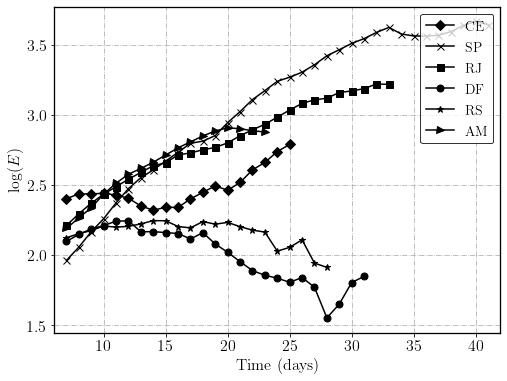

gaussian-process
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-gaussian-process-RMSE.png


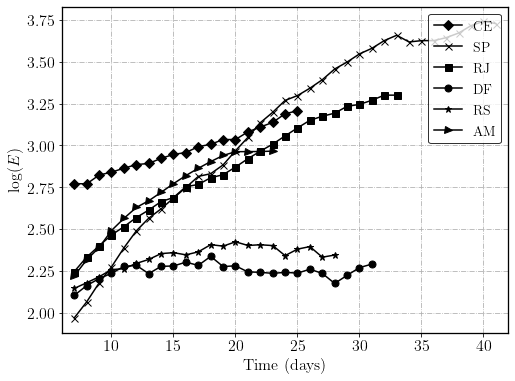

mlp
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-mlp-RMSE.png


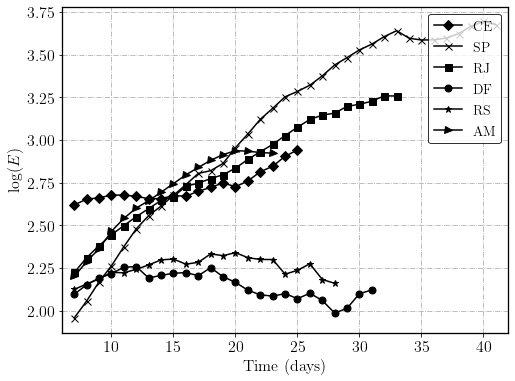

svr
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-svr-RMSE.png


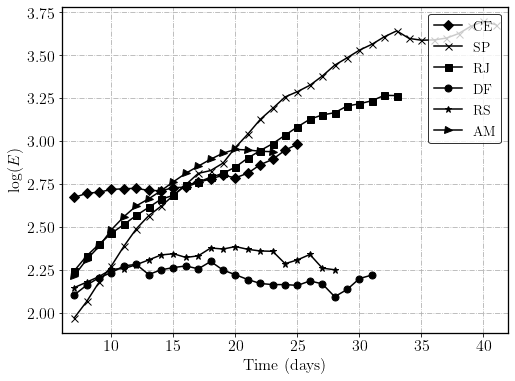

exponential-holt
CE
SP
RJ
DF
RS
AM
../results/figures/aggregated-exponential-holt-RMSE.png


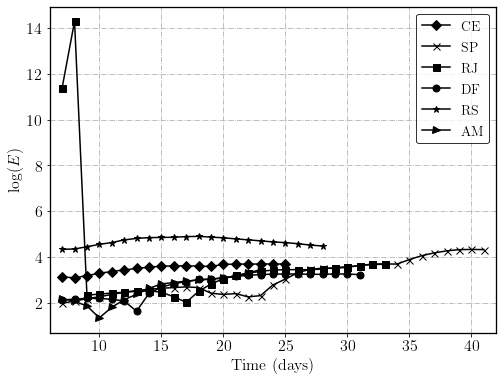

In [14]:
metric = 'RMSE'

plt.figure(figsize=(10,8))

FONTSIZE=16
STATES_2 = ['CE', 'SP', 'RJ', 'DF', 'RS', 'AM']
MARKERS = ['D', 'x', 's', 'o', '*', '>']

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

for model in MODELS:
    fig = plt.figure(figsize=(8, 6))
    print(model)
    id_state = 0
    for state in STATES_2:
        print(state)
        df, days = get_data(df_results_agg, state)

        g = df.groupby(by=['metric', 'model'])
    
        data = g.get_group((metric, model)).drop(['state', 'model', 'metric'], axis=1)

        ax = fig.add_subplot(1, 1, 1)

        x = days
        # Filter data
        y = data.iloc[i].values
        
        ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)
        
        id_state += 1

    # Set limits
    plt.xlim(6, 42)
    # plt.ylim(-0.5, 11)

    #
    for ori in ax.spines:
        ax.spines[ori].set_linewidth(1.3)

    #
    ax.set_ylabel('$\log(E)$', fontsize=FONTSIZE)
    ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
    
    plt.yticks(fontsize=FONTSIZE)
    plt.xticks(fontsize=FONTSIZE)
    
    leg = plt.legend(fontsize=FONTSIZE-2, loc='upper right')
    leg.get_frame().set_edgecolor('k')
    
    plt.grid(ls='-.')

    #
    filename = path.join(RESULTS_FOLDER, 'figures', f'aggregated-{model}-{metric}.png')
    print(filename)
    plt.savefig(filename, dpi=300)
    #
    plt.show()

# Figures for `windowed` methodology

In [15]:
df_results_win = pd.read_csv(path.join(RESULTS_FOLDER, 'results-windowed.csv'), index_col=0)
df_results_win.head()

,state,model,metric,yhat_model_1_to_7,yhat_model_2_to_8,yhat_model_3_to_9,yhat_model_4_to_10,yhat_model_5_to_11,yhat_model_6_to_12,yhat_model_7_to_13,...,yhat_model_52_to_58,yhat_model_53_to_59,yhat_model_54_to_60,yhat_model_55_to_61,yhat_model_56_to_61,yhat_model_57_to_61,yhat_model_58_to_61,yhat_model_59_to_61,yhat_model_60_to_61,yhat_model_61_to_61
0,AC,linear-regression,MAE,5.142857,6.100000,6.019048,3.695238,6.019048,10.390476,11.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AC,linear-regression,RMSE,6.061252,7.196891,7.156083,4.282618,7.131419,11.688066,13.012919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AC,linear-regression,MSLE,0.016516,0.021357,0.019402,0.006636,0.015282,0.036865,0.044110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AC,gaussian-process,MAE,17.453821,20.273564,23.690079,26.427523,32.900518,36.588681,40.153260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AC,gaussian-process,RMSE,20.098141,23.085653,26.382108,29.244598,36.125220,40.769514,44.899956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df, days = get_data(df_results_win, 'CE')
df

,state,model,metric,yhat_model_1_to_7,yhat_model_2_to_8,yhat_model_3_to_9,yhat_model_4_to_10,yhat_model_5_to_11,yhat_model_6_to_12,yhat_model_7_to_13,...,yhat_model_10_to_16,yhat_model_11_to_17,yhat_model_12_to_18,yhat_model_13_to_19,yhat_model_14_to_20,yhat_model_15_to_21,yhat_model_16_to_22,yhat_model_17_to_23,yhat_model_18_to_24,yhat_model_19_to_25
75,CE,linear-regression,MAE,205.177679,218.795238,215.926190,204.226190,193.445238,181.978571,150.535714,...,57.033333,83.757143,163.950000,261.188095,339.395238,302.016667,232.800000,210.414286,219.142857,265.780952
76,CE,linear-regression,RMSE,253.683379,257.863115,255.182628,242.948715,232.100293,219.676978,186.401541,...,64.600191,95.297456,189.157698,302.070251,386.570619,369.575117,341.196382,349.727693,330.504595,374.367118
77,CE,linear-regression,MSLE,0.146115,0.122770,0.095121,0.068898,0.050906,0.038209,0.022686,...,0.002797,0.004366,0.014631,0.034767,0.052964,0.036739,0.021698,0.017683,0.014087,0.016925
78,CE,gaussian-process,MAE,506.670712,571.359749,718.910905,805.586533,909.527262,979.743723,1050.006815,...,1251.519379,1326.490697,1411.031124,1503.297784,1600.138440,1706.178114,1832.804047,1967.336304,2103.514825,2255.325139
79,CE,gaussian-process,RMSE,591.600874,643.343017,786.892669,871.771839,974.708831,1045.138657,1114.739399,...,1313.250097,1389.213654,1473.057029,1568.969026,1667.467964,1786.862338,1928.877324,2081.082177,2236.378040,2400.489832
80,CE,gaussian-process,MSLE,3.191043,2.712898,7.024895,9.595647,39.954469,40.692542,41.412950,...,43.435104,44.109717,44.882047,45.543530,46.231865,46.829391,47.664801,48.419772,49.159068,50.076655
81,CE,mlp,MAE,349.753438,432.655916,502.903142,580.334203,648.810218,724.035413,802.892427,...,1012.358643,1095.599574,1176.529741,1275.406689,1373.029834,1485.880115,1619.054647,1760.893373,1901.273076,2054.585952
82,CE,mlp,RMSE,432.424853,507.361477,574.367709,650.388741,714.424019,786.758246,863.975690,...,1061.717287,1144.608829,1222.589891,1324.086564,1421.990363,1544.118085,1694.749631,1854.226887,2007.957699,2174.430056
83,CE,mlp,MSLE,0.680363,0.869772,1.025392,1.252348,1.377189,1.576582,1.819311,...,2.335501,2.586971,2.732471,2.987872,3.181614,3.405004,3.725296,4.032063,4.254607,4.552141
84,CE,svr,MAE,381.916292,472.440712,553.507379,639.323128,711.708022,735.674021,746.874021,...,766.540687,756.674021,776.740687,834.740687,880.340687,958.140687,1034.674021,1107.007354,1127.874021,1185.674021


### metric = `MSLE`

linear-regression
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-linear-regression-MSLE.png


<Figure size 720x576 with 0 Axes>

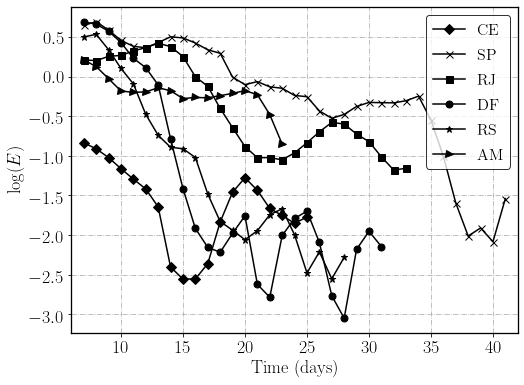

gaussian-process
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-gaussian-process-MSLE.png


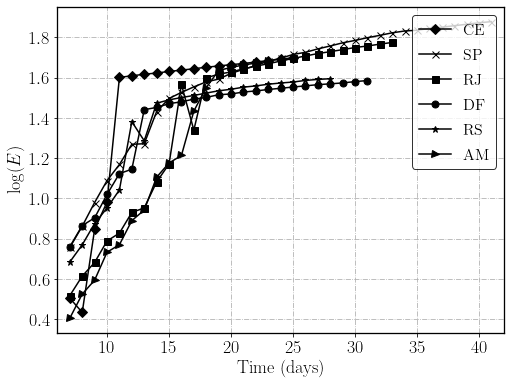

mlp
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-mlp-MSLE.png


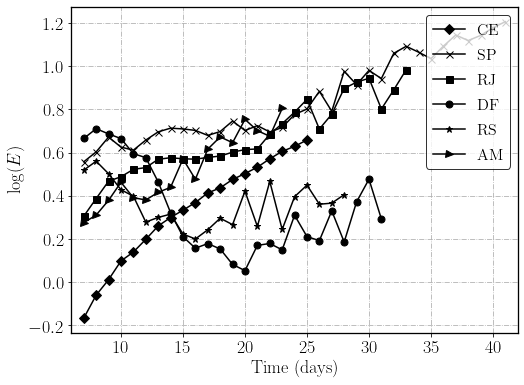

svr
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-svr-MSLE.png


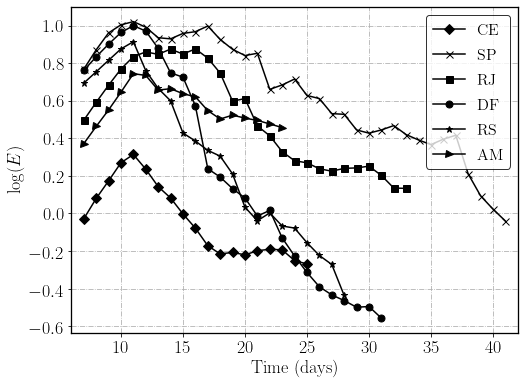

exponential-holt
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-exponential-holt-MSLE.png


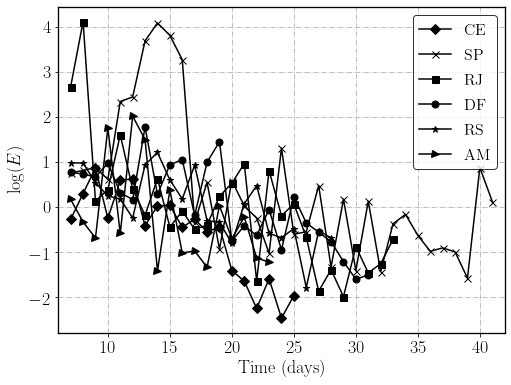

In [17]:
metric = 'MSLE'

plt.figure(figsize=(10,8))

FONTSIZE=18
STATES_2 = ['CE', 'SP', 'RJ', 'DF', 'RS', 'AM']
MARKERS = ['D', 'x', 's', 'o', '*', '>']

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')



for model in MODELS:
    fig = plt.figure(figsize=(8, 6))
    print(model)
    id_state = 0
    for state in STATES_2:
        print(state)
        df, days = get_data(df_results_win, state)

        g = df.groupby(by=['metric', 'model'])
    
        data = g.get_group((metric, model)).drop(['state', 'model', 'metric'], axis=1)

        ax = fig.add_subplot(1, 1, 1)

        x = days
        # Filter data
        y = data.iloc[i].values
        
        ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)
        
        id_state += 1

    # Set limits
    plt.xlim(6, 42)
    # plt.ylim(-0.5, 11)

    #
    for ori in ax.spines:
        ax.spines[ori].set_linewidth(1.3)

    #
    ax.set_ylabel('$\log(E)$', fontsize=FONTSIZE)
    ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
    
    plt.yticks(fontsize=FONTSIZE)
    plt.xticks(fontsize=FONTSIZE)
    
    leg = plt.legend(fontsize=FONTSIZE-2, loc='upper right')
    leg.get_frame().set_edgecolor('k')

    plt.grid(ls='-.')

    #
    filename = path.join(RESULTS_FOLDER, 'figures', f'windowed-{model}-{metric}.png')
    print(filename)
    plt.savefig(filename, dpi=300)
    #
    plt.show()

### metric = `RMSE`

linear-regression
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-linear-regression-RMSE.png


<Figure size 720x576 with 0 Axes>

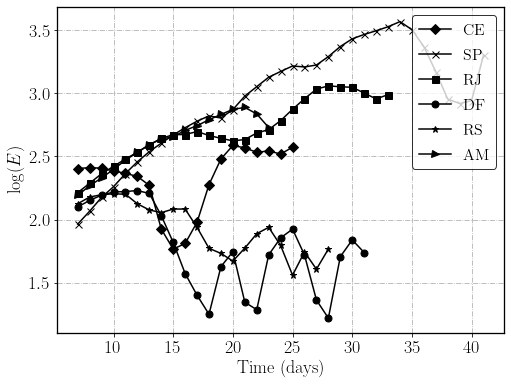

gaussian-process
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-gaussian-process-RMSE.png


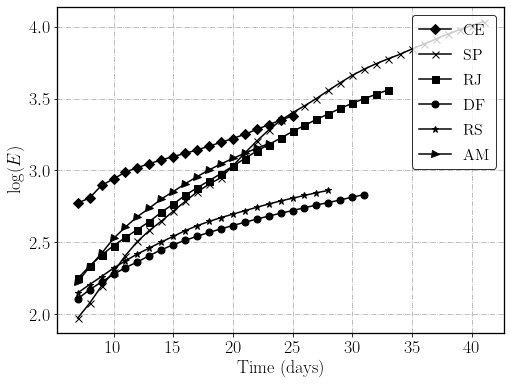

mlp
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-mlp-RMSE.png


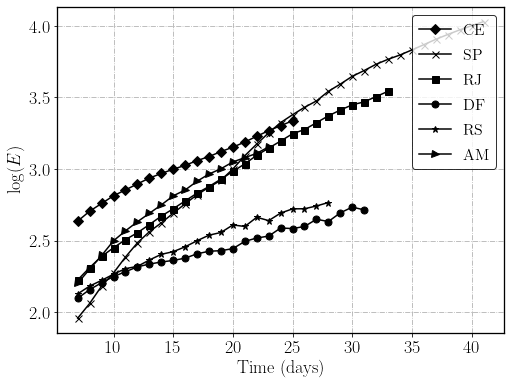

svr
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-svr-RMSE.png


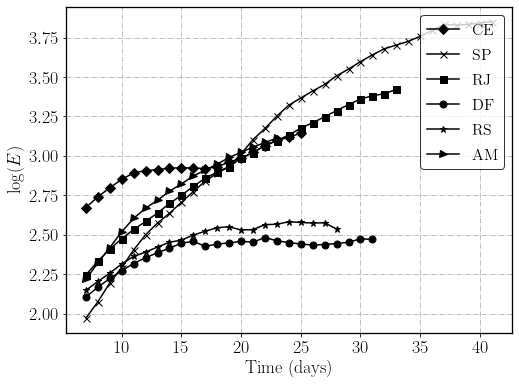

exponential-holt
CE
SP
RJ
DF
RS
AM
../results/figures/windowed-exponential-holt-RMSE.png


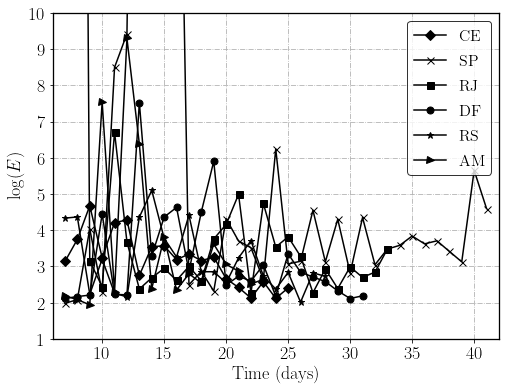

In [18]:
metric = 'RMSE'

plt.figure(figsize=(10,8))

FONTSIZE=18
STATES_2 = ['CE', 'SP', 'RJ', 'DF', 'RS', 'AM']
MARKERS = ['D', 'x', 's', 'o', '*', '>']

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


for model in MODELS:
    fig = plt.figure(figsize=(8, 6))
    print(model)
    id_state = 0
    for state in STATES_2:
        print(state)
        df, days = get_data(df_results_win, state)

        g = df.groupby(by=['metric', 'model'])
    
        data = g.get_group((metric, model)).drop(['state', 'model', 'metric'], axis=1)

        ax = fig.add_subplot(1, 1, 1)

        x = days
        # Filter data
        y = data.iloc[i].values
        
        ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)
        
        id_state += 1

    # Set limits
    if model == 'exponential-holt':
        plt.xlim(6, 42)
        plt.ylim(1, 10)

    #
    for ori in ax.spines:
        ax.spines[ori].set_linewidth(1.3)

    #
    ax.set_ylabel('$\log(E)$', fontsize=FONTSIZE)
    ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
    
    plt.yticks(fontsize=FONTSIZE)
    plt.xticks(fontsize=FONTSIZE)
    
    leg = plt.legend(fontsize=FONTSIZE-2, loc='upper right')
    leg.get_frame().set_edgecolor('k')
    plt.grid(ls='-.')

    #
    filename = path.join(RESULTS_FOLDER, 'figures', f'windowed-{model}-{metric}.png')
    print(filename)
    plt.savefig(filename, dpi=300)
    #
    plt.show()

# Figure to strategy of similarity analyses

In [19]:
df_results_agg

,state,model,metric,yhat_model_1_to_7,yhat_model_1_to_8,yhat_model_1_to_9,yhat_model_1_to_10,yhat_model_1_to_11,yhat_model_1_to_12,yhat_model_1_to_13,...,yhat_model_1_to_52,yhat_model_1_to_53,yhat_model_1_to_54,yhat_model_1_to_55,yhat_model_1_to_56,yhat_model_1_to_57,yhat_model_1_to_58,yhat_model_1_to_59,yhat_model_1_to_60,yhat_model_1_to_61
0,AC,linear-regression,MAE,5.142857,5.671429,4.376667,3.717818,8.189333,7.825874,9.117216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AC,linear-regression,RMSE,6.061252,6.727641,5.474591,4.349823,9.245433,8.824073,9.825322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AC,linear-regression,MSLE,0.016516,0.019184,0.012799,0.006493,0.025928,0.021202,0.025726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AC,gaussian-process,MAE,17.453821,19.399558,22.624428,15.257678,12.842851,16.317758,18.761345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AC,gaussian-process,RMSE,20.098141,22.073480,25.305447,19.105770,18.690582,23.408477,26.532628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,TO,svr,RMSE,8.122756,8.458946,8.416532,9.598080,9.984616,10.112330,9.990207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,TO,svr,MSLE,0.386829,0.362186,0.307143,0.396814,0.385335,0.355268,0.312145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,TO,exponential-holt,MAE,1.435962,1.762898,2.672079,3.666345,3.482395,4.050943,5.017515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,TO,exponential-holt,RMSE,1.817653,2.446396,3.881101,5.226256,5.169748,6.084118,7.518832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
g = df_results_agg.groupby(by=['state', 'metric', 'model']).agg(['mean'])
g.to_csv(path.join(RESULTS_FOLDER, 'results-aggregated-agg-2.csv'), sep='\t')

In [21]:
g = df_results_agg.groupby(by=['state', 'metric', 'model']).agg(['mean'])
g.to_csv(path.join(RESULTS_FOLDER, 'results-aggregated-agg.csv'))

In [22]:
g = df_results_win.groupby(by=['state', 'metric', 'model']).agg(['mean'])
g.to_csv(path.join(RESULTS_FOLDER, 'results-windowed-agg-2.csv'), sep='\t')

In [23]:
g = df_results_win.groupby(by=['state', 'metric', 'model']).agg(['mean'])
g.to_csv(path.join(RESULTS_FOLDER, 'results-windowed-agg.csv'))

# Figures based on the Exponential Similarity Analyses

In [44]:
from statsmodels.tsa.api import Holt

def holt_predict(X, var_future, smoothing_level=0.5, smoothing_slope=0.05):
#     print(X)
    model_holt = Holt(X['y'], exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, optimized=False)
    forecast = model_holt.forecast(var_future)

    # Check if predictions are belows yesterday
#     last_value = porra_df.iloc[-1]['y']
#     forecast = utils.rescale_yhat(forecast.values, last_value)
    return forecast

In [25]:
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interactive


def f(state='TO', days_to_train1=7, days_to_train2=14, smoothing1=0.5, smoothing2=0.5, slope1=0.05, slope2=0.05):
    
    
    df_state = utils.download_state(state=state)
    df_state = df_state[df_state['cases'] != 0]
    dayone = df_state[df_state['cases'] != 0].index[0]
    days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
    X = days.reshape(-1,1)
    y = utils.get_labels(df_state['cases']).reshape(-1,1)
    X, y = utils.check_inputs(X, y)

    DAYS_TO_TRAIN = 7
    forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
    y_last_7 = forecast_last_7.values
    X_last_7 = np.arange(X[-1], X[-1]+14, 1)
    X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
    ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')


    
    DAYS_TO_TRAIN_1 = days_to_train1
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
    forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=smoothing1, smoothing_slope=slope1)
    y_first_7 = forecast_first_7.values
    X_first_7 = X[DAYS_TO_TRAIN_1:]
    X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
    ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')
    
    
    DAYS_TO_TRAIN_2 = days_to_train2
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
    forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=smoothing2, smoothing_slope=slope2)
    y_first_14 = forecast_first_14.values
    X_first_14 = X[DAYS_TO_TRAIN_2:]
    X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
    ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')
    
    
    plt.figure(figsize=(7,5))

    plt.plot(X, y, 'black', linewidth=2, label='Real Data')
    plt.plot(X_first_7, y_first_7, label='Crescimento exponencial usando os primeiros {} dias'.format(DAYS_TO_TRAIN_1))
    plt.plot(X_first_14, y_first_14, label='Crescimento exponencial usando os primeiros {} dias'.format(DAYS_TO_TRAIN_2))
    plt.plot(X_last_7, y_last_7, label='Predição futura')

    plt.legend(fontsize=10)
    plt.ylim(0, y[-1]*5)

    plt.savefig('{}-comparativo.png'.format(state))

    plt.show()

In [26]:
STATES = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
         'DF', 'ES', 'GO', 'MA', 'MT', 'MS',
         'MG', 'PA', 'PB', 'PR', 'PE', 'PI',
         'RJ', 'RN', 'RO', 'RS', 'RR', 'SC',
         'SE', 'SP', 'TO']

interactive_plot = interactive(f, state=STATES, days_to_train1=(3, 14), days_to_train2=(10, 21), 
                                smoothing1=(0.2, 5, 0.01), smoothing2=(0.2, 5, 0.01), slope1=(0.01, 3, 0.01), slope2=(0.01, 3, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='state', index=26, options=('AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF…

                y
data             
2020-04-30   9453
2020-01-05  10166
2020-02-05  10546
2020-03-05  11139
2020-04-05  11721
2020-05-05  12391
2020-06-05  13295
             y
data          
2020-05-03   1
2020-06-03   1
2020-07-03   2
2020-08-03   3
2020-09-03   3
2020-10-03   8
2020-11-03  13
2020-12-03  16
2020-03-13  16
              y
data           
2020-05-03    1
2020-06-03    1
2020-07-03    2
2020-08-03    3
2020-09-03    3
2020-10-03    8
2020-11-03   13
2020-12-03   16
2020-03-13   16
2020-03-14   22
2020-03-15   24
2020-03-16   31
2020-03-17   33
2020-03-18   45
2020-03-19   65
2020-03-20  109


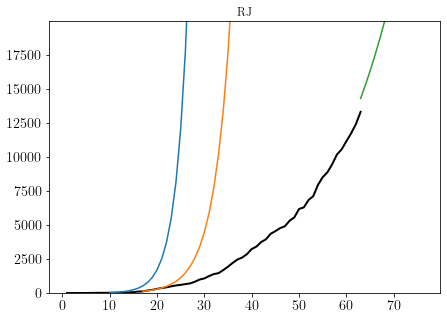

                y
data             
2020-04-30  28698
2020-01-05  30374
2020-02-05  31174
2020-03-05  31772
2020-04-05  32187
2020-05-05  34053
2020-06-05  37853
             y
data          
2020-02-26   1
2020-02-27   1
2020-02-28   1
2020-02-29   2
2020-01-03   2
2020-02-03   2
2020-03-03   2
2020-04-03   3
2020-05-03   6
2020-06-03  10
             y
data          
2020-02-26   1
2020-02-27   1
2020-02-28   1
2020-02-29   2
2020-01-03   2
2020-02-03   2
2020-03-03   2
2020-04-03   3
2020-05-03   6
2020-06-03  10
2020-07-03  13
2020-08-03  16
2020-09-03  16
2020-10-03  19
2020-11-03  30
2020-12-03  42
2020-03-13  56


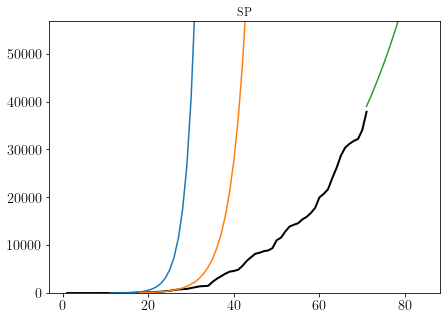

                y
data             
2020-04-30   7861
2020-01-05   8000
2020-02-05   8309
2020-03-05   8379
2020-04-05  11142
2020-05-05  11470
2020-06-05  12310
              y
data           
2020-03-14   27
2020-03-15   33
2020-03-16   46
2020-03-17   77
2020-03-18   96
2020-03-19  143
2020-03-20  215
              y
data           
2020-03-14   27
2020-03-15   33
2020-03-16   46
2020-03-17   77
2020-03-18   96
2020-03-19  143
2020-03-20  215
2020-03-20  215
2020-03-21  266
2020-03-22  328
2020-03-23  380
2020-03-24  449
2020-03-25  518
2020-03-26  606


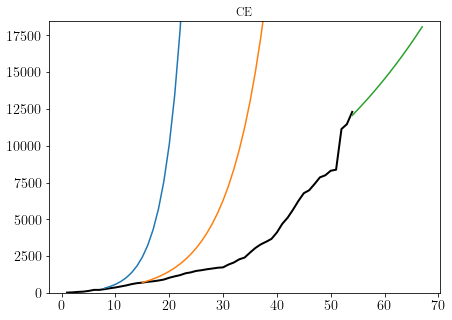

In [27]:
STATES_2 = ['RJ', 'SP', 'CE']

SLOPES_1 = [0.46, 0.41, 0.16]
SLOPES_2 = [0.16, 0.41, 0.40]

smoothing = 0.5


DAYS_TO_TRAIN_1_LIST = [9, 10, 7]
DAYS_TO_TRAIN_2_LIST = [16, 17, 14]

for i in range(len(STATES_2)):

    df_state = utils.download_state(state=STATES_2[i])
    df_state = df_state[df_state['cases'] != 0]
    dayone = df_state[df_state['cases'] != 0].index[0]
    days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
    X = days.reshape(-1,1)
    y = utils.get_labels(df_state['cases']).reshape(-1,1)
    X, y = utils.check_inputs(X, y)

    DAYS_TO_TRAIN = 7
    forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
    y_last_7 = forecast_last_7.values
    X_last_7 = np.arange(X[-1], X[-1]+14, 1)
    X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
    ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



    DAYS_TO_TRAIN_1 = DAYS_TO_TRAIN_1_LIST[i]
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
    forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=SLOPES_1[i])
    y_first_7 = forecast_first_7.values
    X_first_7 = X[DAYS_TO_TRAIN_1:]
    X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
    ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')


    DAYS_TO_TRAIN_2 = DAYS_TO_TRAIN_2_LIST[i]
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
    forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=SLOPES_2[i])
    y_first_14 = forecast_first_14.values
    X_first_14 = X[DAYS_TO_TRAIN_2:]
    X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
    ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')


    plt.figure(figsize=(7,5))

    plt.plot(X, y, 'black', linewidth=2, label='Real Data')
    plt.plot(X_first_7, y_first_7, label='Crescimento exponencial usando os primeiros {} dias'.format(DAYS_TO_TRAIN_1))
    plt.plot(X_first_14, y_first_14, label='Crescimento exponencial usando os primeiros {} dias'.format(DAYS_TO_TRAIN_2))
    plt.plot(X_last_7, y_last_7, label='Predição futura')

#     plt.legend(fontsize=10)
    plt.ylim(0, y[-1]*1.5)

    #     plt.savefig('{}-comparativo.png'.format(state))

    plt.title(f'{STATES_2[i]}')
    plt.show()

## For **CE**

In [28]:
def theta(x1, x2):
    return round(float(np.log10(np.dot(x1, x2))), 2)

                y
data             
2020-04-30   7861
2020-01-05   8000
2020-02-05   8309
2020-03-05   8379
2020-04-05  11142
2020-05-05  11470
2020-06-05  12310
              y
data           
2020-03-14   27
2020-03-15   33
2020-03-16   46
2020-03-17   77
2020-03-18   96
2020-03-19  143
2020-03-20  215
              y
data           
2020-03-14   27
2020-03-15   33
2020-03-16   46
2020-03-17   77
2020-03-18   96
2020-03-19  143
2020-03-20  215
2020-03-20  215
2020-03-21  266
2020-03-22  328
2020-03-23  380
2020-03-24  449
2020-03-25  518
2020-03-26  606


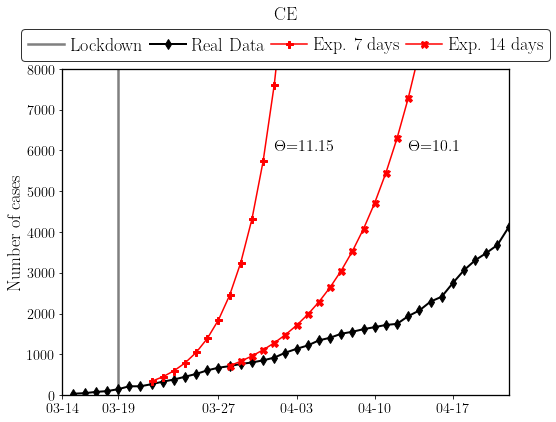

In [29]:
state='CE'
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

%matplotlib inline

#

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
y_last_7 = forecast_last_7.values
X_last_7 = np.arange(X[-1], X[-1]+14, 1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



DAYS_TO_TRAIN_1 = 7
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.16)
y_first_7 = forecast_first_7.values
X_first_7 = X[DAYS_TO_TRAIN_1:]
X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')


DAYS_TO_TRAIN_2 = 14
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.40)
y_first_14 = forecast_first_14.values
X_first_14 = X[DAYS_TO_TRAIN_2:]
X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('19/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

##

ax.plot(X, y, 'black', linewidth=2, marker='d', markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='r', marker='P', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='r', marker='X', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
# ax.plot(X_last_7, y_last_7, c='b', marker='P', markersize=7, label='Predição futura')

# ax.fill_between(X_first_7[:y_first_14.shape[0]].reshape(-1), y_first_7[:y_first_14.shape[0]], y_first_14, color='#539ecd')
# ax.fill_between(X_first_7.reshape(-1), y_first_7, y[:y_first_7.shape[0]].reshape(-1), color='#539ecd')

# Change xticks
days = utils.format_date(days, date_string_input='%d/%m/%Y', date_string_output='%m-%d')

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [0, 5, 14, 21, 28, 35]
labels = [days[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)




# print(locs)
# plt.xticks([x for x in (range(1, DAYS_TO_SHOW_IN_TICKS, 2))], days)


# xticks([0, 1, 2], ['January', 'February', 'March'],
# ...        rotation=20)  # Set text labels and properties.
#
leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')


ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    
    
# Plot arrow

# ax.arrow(12.04, 4000, 12.05, 5)
# ax.annotate("", xy=(12, 4000), xytext=(13, 5), arrowprops=dict(arrowstyle="->"))
t1 = theta(y_first_7[8:38], y[8:38])
t2 = theta(y_first_14, y[14:y_first_14.shape[0]+14])
plt.text(19, 6000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(31, 6000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

# plt.text(13, 4000, f'O={theta(y_first_14, y[14:31+14])}', fontsize=FONTSIZE)

plt.ylim(0, 8000)
plt.xlim(0, 40)

plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

# plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

## Log transformation

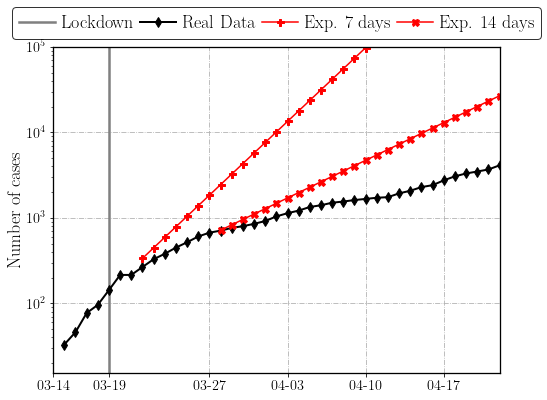

In [30]:
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('19/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

ax.plot(X, y, 'black', linewidth=2, marker='d', markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='r', marker='P', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='r', marker='X', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))

days = utils.format_date(days, date_string_input='%d/%m/%Y', date_string_output='%m-%d')

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [0, 5, 14, 21, 28, 35, 42]
labels = [days[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)

leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)

ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
plt.yscale('log')

ax.grid(which='major', linestyle='-.')

# plt.grid('-.')
plt.ylim(0, 10e4)
plt.xlim(0, 40)
plt.show()

## For RJ

                y
data             
2020-04-30   9453
2020-01-05  10166
2020-02-05  10546
2020-03-05  11139
2020-04-05  11721
2020-05-05  12391
2020-06-05  13295
             y
data          
2020-05-03   1
2020-06-03   1
2020-07-03   2
2020-08-03   3
2020-09-03   3
2020-10-03   8
2020-11-03  13
2020-12-03  16
2020-03-13  16
              y
data           
2020-05-03    1
2020-06-03    1
2020-07-03    2
2020-08-03    3
2020-09-03    3
2020-10-03    8
2020-11-03   13
2020-12-03   16
2020-03-13   16
2020-03-14   22
2020-03-15   24
2020-03-16   31
2020-03-17   33
2020-03-18   45
2020-03-19   65
2020-03-20  109


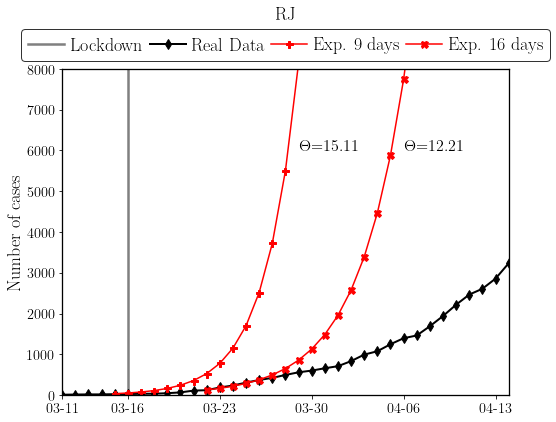

In [31]:
state='RJ'
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

%matplotlib inline

#

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
y_last_7 = forecast_last_7.values
X_last_7 = np.arange(X[-1], X[-1]+14, 1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



DAYS_TO_TRAIN_1 = 9
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.46)
y_first_7 = forecast_first_7.values
X_first_7 = X[DAYS_TO_TRAIN_1:]
X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')


DAYS_TO_TRAIN_2 = 16
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.16)
y_first_14 = forecast_first_14.values
X_first_14 = X[DAYS_TO_TRAIN_2:]
X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('16/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

##

ax.plot(X, y, 'black', linewidth=2, marker='d', markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='r', marker='P', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='r', marker='X', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
# ax.plot(X_last_7, y_last_7, c='r', marker='P', markersize=7, label='Predição futura')

# ax.fill_between(X_first_7[:y_first_14.shape[0]].reshape(-1), y_first_7[:y_first_14.shape[0]], y_first_14, color='#539ecd')
# ax.fill_between(X_first_7.reshape(-1), y_first_7, y[:y_first_7.shape[0]].reshape(-1), color='#539ecd')

# Change xticks
days = utils.format_date(days, date_string_input='%d/%m/%Y', date_string_output='%m-%d')

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [6, 11, 18, 25, 32, 39]
labels = [days[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)




# print(locs)
# plt.xticks([x for x in (range(1, DAYS_TO_SHOW_IN_TICKS, 2))], days)


# xticks([0, 1, 2], ['January', 'February', 'March'],
# ...        rotation=20)  # Set text labels and properties.
#
ax.legend(fontsize=FONTSIZE)
leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, handletextpad=0.3, columnspacing=0.4)
leg.get_frame().set_edgecolor('k')



ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    
    
# Plot arrow

# ax.arrow(12.04, 4000, 12.05, 5)
# ax.annotate("", xy=(12, 4000), xytext=(13, 5), arrowprops=dict(arrowstyle="->"))
t1 = theta(y_first_7, y[9:y_first_7.shape[0]+14])
t2 = theta(y_first_14, y[14:y_first_14.shape[0]+14])

plt.text(24, 6000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(32, 6000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

plt.ylim(0, 8000)
plt.xlim(locs[0], 40)
plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

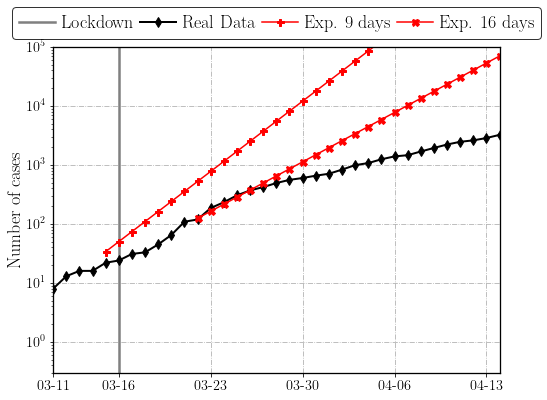

In [32]:
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('16/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

ax.plot(X, y, 'black', linewidth=2, marker='d', markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='r', marker='P', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='r', marker='X', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))

days = utils.format_date(days, date_string_input='%d/%m/%Y', date_string_output='%m-%d')

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [6, 11, 18, 25, 32, 39]
labels = [days[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)

leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)

ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
plt.yscale('log')

ax.grid(which='major', linestyle='-.')

# plt.grid('-.')
plt.ylim(0, 10e4)
plt.xlim(locs[0], 40)
plt.show()

## For SP

                y
data             
2020-04-30  28698
2020-01-05  30374
2020-02-05  31174
2020-03-05  31772
2020-04-05  32187
2020-05-05  34053
2020-06-05  37853
             y
data          
2020-02-26   1
2020-02-27   1
2020-02-28   1
2020-02-29   2
2020-01-03   2
2020-02-03   2
2020-03-03   2
2020-04-03   3
2020-05-03   6
2020-06-03  10
             y
data          
2020-02-26   1
2020-02-27   1
2020-02-28   1
2020-02-29   2
2020-01-03   2
2020-02-03   2
2020-03-03   2
2020-04-03   3
2020-05-03   6
2020-06-03  10
2020-07-03  13
2020-08-03  16
2020-09-03  16
2020-10-03  19
2020-11-03  30
2020-12-03  42
2020-03-13  56


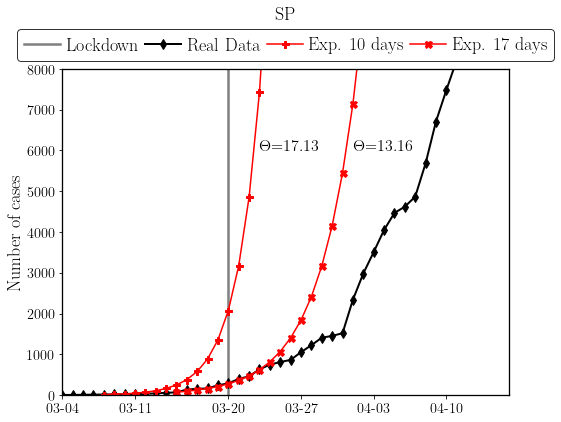

In [33]:
state='SP'
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

%matplotlib inline

#

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
y_last_7 = forecast_last_7.values
X_last_7 = np.arange(X[-1], X[-1]+14, 1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



DAYS_TO_TRAIN_1 = 10
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.41)
y_first_7 = forecast_first_7.values
X_first_7 = X[DAYS_TO_TRAIN_1:]
X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')


DAYS_TO_TRAIN_2 = 17
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.41)
y_first_14 = forecast_first_14.values
X_first_14 = X[DAYS_TO_TRAIN_2:]
X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('20/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

##

ax.plot(X, y, 'black', linewidth=2, marker='d', markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='r', marker='P', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='r', marker='X', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
# ax.plot(X_last_7, y_last_7, c='r', marker='P', markersize=7, label='Predição futura')

# ax.fill_between(X_first_7[:y_first_14.shape[0]].reshape(-1), y_first_7[:y_first_14.shape[0]], y_first_14, color='#539ecd')
# ax.fill_between(X_first_7.reshape(-1), y_first_7, y[:y_first_7.shape[0]].reshape(-1), color='#539ecd')

# Change xticks
days = utils.format_date(days, date_string_input='%d/%m/%Y', date_string_output='%m-%d')

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [7, 14, 23, 30, 37, 44, 51]
labels = [days[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)




# print(locs)
# plt.xticks([x for x in (range(1, DAYS_TO_SHOW_IN_TICKS, 2))], days)


# xticks([0, 1, 2], ['January', 'February', 'March'],
# ...        rotation=20)  # Set text labels and properties.
#
ax.legend(fontsize=FONTSIZE)
leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, handletextpad=0.3, columnspacing=0.4)
leg.get_frame().set_edgecolor('k')


ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    
    
# Plot arrow

# ax.arrow(12.04, 4000, 12.05, 5)
# ax.annotate("", xy=(12, 4000), xytext=(13, 5), arrowprops=dict(arrowstyle="->"))



t1 = theta(y_first_7, y[8:y_first_7.shape[0]+8])
t2 = theta(y_first_14, y[14:y_first_14.shape[0]+14])

plt.text(26, 6000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(35, 6000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)
# plt.text(13, 4000, f'O={theta(y_first_14, y[14:31+14])}', fontsize=FONTSIZE)

plt.ylim(0, 8000)
plt.xlim(locs[0], 50)

plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

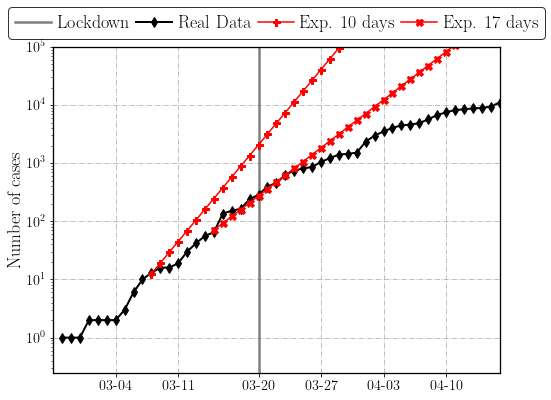

In [34]:
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('20/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

ax.plot(X, y, 'black', linewidth=2, marker='d', markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='r', marker='P', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='r', marker='X', markersize=7, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))

days = utils.format_date(days, date_string_input='%d/%m/%Y', date_string_output='%m-%d')

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [7, 14, 23, 30, 37, 44, 51]
labels = [days[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)

leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)

ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
plt.yscale('log')

ax.grid(which='major', linestyle='-.')

# plt.grid('-.')
plt.ylim(0, 10e4)
plt.xlim(0, 50)
plt.show()

# 4 - Figures transforming to log and seeing exponential trend

## CE

                y
data             
2020-04-30   7861
2020-01-05   8000
2020-02-05   8309
2020-03-05   8379
2020-04-05  11142
2020-05-05  11470
2020-06-05  12310
              y
data           
2020-03-14   27
2020-03-15   33
2020-03-16   46
2020-03-17   77
2020-03-18   96
2020-03-19  143
2020-03-20  215
              y
data           
2020-03-14   27
2020-03-15   33
2020-03-16   46
2020-03-17   77
2020-03-18   96
2020-03-19  143
2020-03-20  215
2020-03-20  215
2020-03-21  266
2020-03-22  328
2020-03-23  380
2020-03-24  449
2020-03-25  518
2020-03-26  606


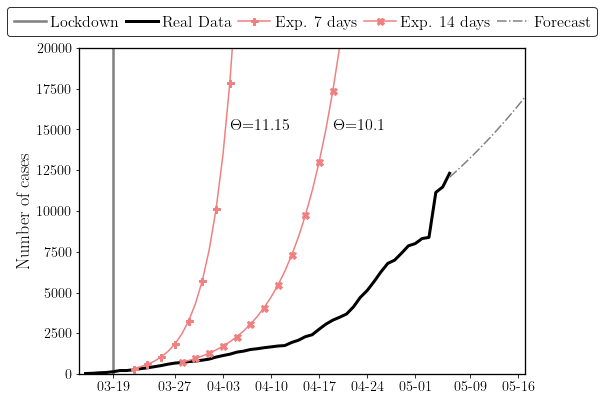

In [35]:
state='CE'
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

%matplotlib inline

#

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
y_last_7 = forecast_last_7.values
X_last_7 = np.arange(X[-1], X[-1]+14, 1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



DAYS_TO_TRAIN_1 = 7
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.16)
y_first_7 = forecast_first_7.values
X_first_7 = X[DAYS_TO_TRAIN_1:]
X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')


DAYS_TO_TRAIN_2 = 14
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.40)
y_first_14 = forecast_first_14.values
X_first_14 = X[DAYS_TO_TRAIN_2:]
X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('19/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

##

ax.plot(X, y, 'black', linewidth=3, markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='lightcoral', marker='P', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='lightcoral', marker='X', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
ax.plot(X_last_7, y_last_7, c='gray', linewidth=1.5, linestyle='-.', markersize=7, label='Forecast')

# ax.fill_between(X_first_7[:y_first_14.shape[0]].reshape(-1), y_first_7[:y_first_14.shape[0]], y_first_14, color='#539ecd')
# ax.fill_between(X_first_7.reshape(-1), y_first_7, y[:y_first_7.shape[0]].reshape(-1), color='#539ecd')

# Change xticks
datetime_last_day = datetime.strptime(days[-1], '%d/%m/%Y')
dates = [datetime.strptime(x, '%d/%m/%Y') for x in days]
for i in range(1, 15):
    dates.append(datetime_last_day + timedelta(days=i))
    
dates_tormated = [x.strftime('%m-%d') for x in dates]

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [5, 14, 21, 28, 35, 42, 49, 57, 64]
labels = [dates_tormated[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)

# print(locs)
# plt.xticks([x for x in (range(1, DAYS_TO_SHOW_IN_TICKS, 2))], days)


# xticks([0, 1, 2], ['January', 'February', 'March'],
# ...        rotation=20)  # Set text labels and properties.
#
# leg = ax.legend(fontsize=FONTSIZE, bbox_to_anchor=(1.0,0.785), loc='center left', ncol=1, handletextpad=0.3, columnspacing=0.4)
leg = ax.legend(fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5, handletextpad=0.3, columnspacing=0.4)


leg.get_frame().set_edgecolor('k')


ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    
    
# Plot arrow

# ax.arrow(12.04, 4000, 12.05, 5)
# ax.annotate("", xy=(12, 4000), xytext=(13, 5), arrowprops=dict(arrowstyle="->"))
t1 = theta(y_first_7[8:38], y[8:38])
t2 = theta(y_first_14, y[14:y_first_14.shape[0]+14])
plt.text(22, 15000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(37, 15000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

# plt.text(13, 4000, f'O={theta(y_first_14, y[14:31+14])}', fontsize=FONTSIZE)

plt.ylim(0, 20000)
plt.xlim(0, 65)

# plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo-forecast.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

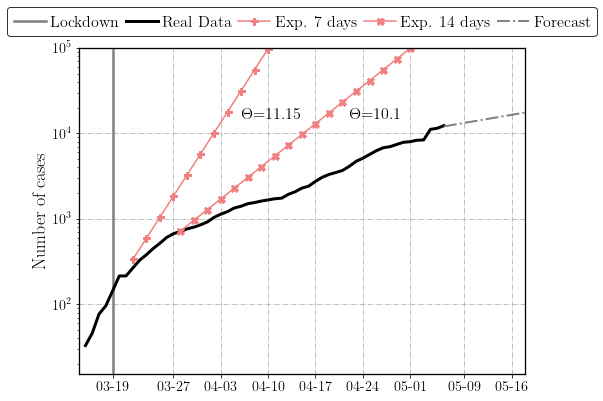

In [36]:
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('19/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

ax.plot(X, y, 'black', linewidth=3, markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='lightcoral', marker='P', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='lightcoral', marker='X', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
ax.plot(X_last_7, y_last_7, c='gray', linewidth=2, linestyle='-.', markersize=7, label='Forecast')

plt.xticks(locs, labels)

leg = ax.legend(fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)

ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
plt.yscale('log')

ax.grid(which='major', linestyle='-.')

plt.text(24, 15000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(40, 15000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

plt.ylim(0, 10e4)
plt.xlim(0, 66)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo-forecast-log.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

## RJ

                y
data             
2020-04-30   9453
2020-01-05  10166
2020-02-05  10546
2020-03-05  11139
2020-04-05  11721
2020-05-05  12391
2020-06-05  13295
             y
data          
2020-05-03   1
2020-06-03   1
2020-07-03   2
2020-08-03   3
2020-09-03   3
2020-10-03   8
2020-11-03  13
2020-12-03  16
2020-03-13  16
              y
data           
2020-05-03    1
2020-06-03    1
2020-07-03    2
2020-08-03    3
2020-09-03    3
2020-10-03    8
2020-11-03   13
2020-12-03   16
2020-03-13   16
2020-03-14   22
2020-03-15   24
2020-03-16   31
2020-03-17   33
2020-03-18   45
2020-03-19   65
2020-03-20  109


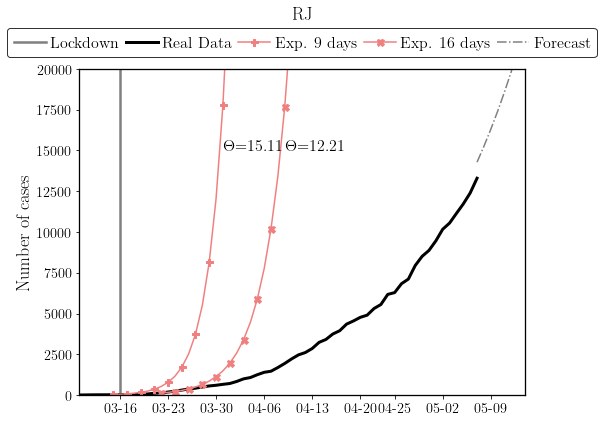

In [37]:
state='RJ'
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

%matplotlib inline

#

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
y_last_7 = forecast_last_7.values
X_last_7 = np.arange(X[-1], X[-1]+14, 1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



DAYS_TO_TRAIN_1 = 9
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.46)
y_first_7 = forecast_first_7.values
X_first_7 = X[DAYS_TO_TRAIN_1:]
X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')


DAYS_TO_TRAIN_2 = 16
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.16)
y_first_14 = forecast_first_14.values
X_first_14 = X[DAYS_TO_TRAIN_2:]
X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('16/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

##

ax.plot(X, y, 'black', linewidth=3, markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='lightcoral', marker='P', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='lightcoral', marker='X', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
ax.plot(X_last_7, y_last_7, c='gray', linewidth=1.5, linestyle='-.', markersize=7, label='Forecast')

# ax.fill_between(X_first_7[:y_first_14.shape[0]].reshape(-1), y_first_7[:y_first_14.shape[0]], y_first_14, color='#539ecd')
# ax.fill_between(X_first_7.reshape(-1), y_first_7, y[:y_first_7.shape[0]].reshape(-1), color='#539ecd')

# Change xticks

# Change xticks
datetime_last_day = datetime.strptime(days[-1], '%d/%m/%Y')
dates = [datetime.strptime(x, '%d/%m/%Y') for x in days]
for i in range(1, 15):
    dates.append(datetime_last_day + timedelta(days=i))
    
dates_tormated = [x.strftime('%m-%d') for x in dates]

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [0, 11, 18, 25, 32, 39, 46, 51, 58, 65, 72]
labels = [dates_tormated[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)

#
leg = ax.legend(fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5, handletextpad=0.3, columnspacing=0.4)
leg.get_frame().set_edgecolor('k')



ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    
    
# Plot arrow

# ax.arrow(12.04, 4000, 12.05, 5)
# ax.annotate("", xy=(12, 4000), xytext=(13, 5), arrowprops=dict(arrowstyle="->"))
t1 = theta(y_first_7, y[9:y_first_7.shape[0]+14])
t2 = theta(y_first_14, y[14:y_first_14.shape[0]+14])

plt.text(26, 15000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(35, 15000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

plt.ylim(0, 20000)
plt.xlim(5, 70)
plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo-forecast.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

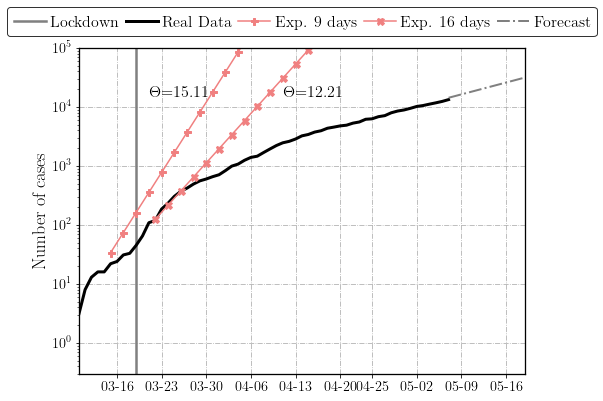

In [38]:
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('19/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

ax.plot(X, y, 'black', linewidth=3, markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='lightcoral', marker='P', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='lightcoral', marker='X', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
ax.plot(X_last_7, y_last_7, c='gray', linewidth=2, linestyle='-.', markersize=7, label='Forecast')

plt.xticks(locs, labels)

leg = ax.legend(fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)

ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
plt.yscale('log')

ax.grid(which='major', linestyle='-.')

plt.text(16, 15000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(37, 15000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

plt.ylim(0, 10e4)
plt.xlim(5, 75)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo-forecast-log.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

## SP

                y
data             
2020-04-30  28698
2020-01-05  30374
2020-02-05  31174
2020-03-05  31772
2020-04-05  32187
2020-05-05  34053
2020-06-05  37853
            y
data         
2020-02-26  1
2020-02-27  1
2020-02-28  1
2020-02-29  2
2020-01-03  2
2020-02-03  2
2020-03-03  2
2020-04-03  3
2020-05-03  6
             y
data          
2020-02-26   1
2020-02-27   1
2020-02-28   1
2020-02-29   2
2020-01-03   2
2020-02-03   2
2020-03-03   2
2020-04-03   3
2020-05-03   6
2020-06-03  10
2020-07-03  13
2020-08-03  16
2020-09-03  16
2020-10-03  19
2020-11-03  30
2020-12-03  42


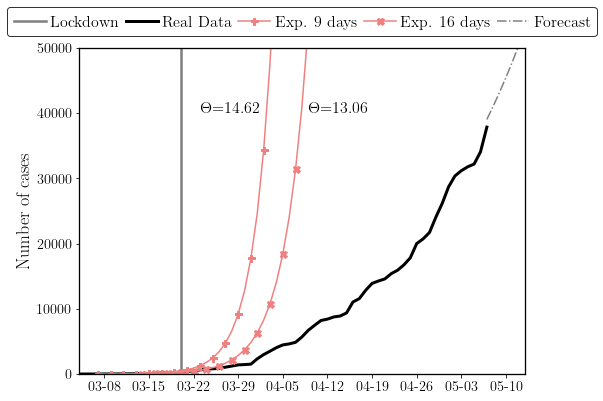

In [39]:
state='SP'
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

%matplotlib inline

#

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
y_last_7 = forecast_last_7.values
X_last_7 = np.arange(X[-1], X[-1]+14, 1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



DAYS_TO_TRAIN_1 = 9
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
forecast_first_7 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.46)
y_first_7 = forecast_first_7.values
X_first_7 = X[DAYS_TO_TRAIN_1:]
X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')


DAYS_TO_TRAIN_2 = 16
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
forecast_first_14 = holt_predict(utils.ajust_df(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=0.5, smoothing_slope=0.16)
y_first_14 = forecast_first_14.values
X_first_14 = X[DAYS_TO_TRAIN_2:]
X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('20/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

##

ax.plot(X, y, 'black', linewidth=3, markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='lightcoral', marker='P', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='lightcoral', marker='X', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
ax.plot(X_last_7, y_last_7, c='gray', linewidth=1.5, linestyle='-.', markersize=7, label='Forecast')

# ax.fill_between(X_first_7[:y_first_14.shape[0]].reshape(-1), y_first_7[:y_first_14.shape[0]], y_first_14, color='#539ecd')
# ax.fill_between(X_first_7.reshape(-1), y_first_7, y[:y_first_7.shape[0]].reshape(-1), color='#539ecd')

# Change xticks

# Change xticks
datetime_last_day = datetime.strptime(days[-1], '%d/%m/%Y')
dates = [datetime.strptime(x, '%d/%m/%Y') for x in days]
for i in range(1, 15):
    dates.append(datetime_last_day + timedelta(days=i))
    
dates_tormated = [x.strftime('%m-%d') for x in dates]

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [0, 11, 18, 25, 32, 39, 46, 53, 60, 67, 74]
labels = [dates_tormated[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)

#
leg = ax.legend(fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5, handletextpad=0.3, columnspacing=0.4)
leg.get_frame().set_edgecolor('k')



ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    
    
# Plot arrow

# ax.arrow(12.04, 4000, 12.05, 5)
# ax.annotate("", xy=(12, 4000), xytext=(13, 5), arrowprops=dict(arrowstyle="->"))
t1 = theta(y_first_7, y[9:y_first_7.shape[0]+14])
t2 = theta(y_first_14, y[14:y_first_14.shape[0]+14])

plt.text(26, 40000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(43, 40000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

plt.ylim(0, 50000)
plt.xlim(7, 77)
# plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo-forecast.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

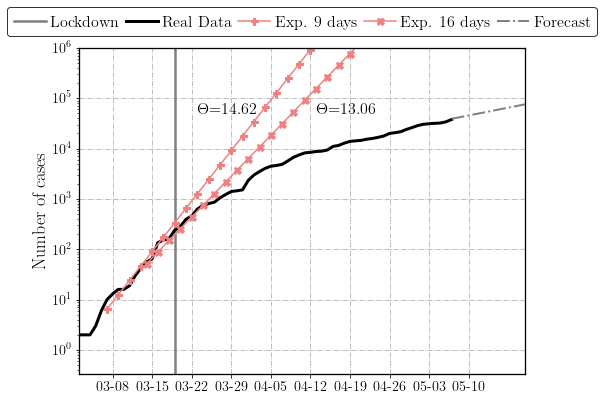

In [40]:
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('19/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

ax.plot(X, y, 'black', linewidth=3, markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='lightcoral', marker='P', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='lightcoral', marker='X', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
ax.plot(X_last_7, y_last_7, c='gray', linewidth=2, linestyle='-.', markersize=7, label='Forecast')

plt.xticks(locs, labels)

leg = ax.legend(fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5, handletextpad=0.3, columnspacing=0.4)

leg.get_frame().set_edgecolor('k')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)

ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
plt.yscale('log')

ax.grid(which='major', linestyle='-.')

plt.text(26, 50000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(47, 50000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

plt.ylim(0, 10e5)
plt.xlim(5, 84)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo-forecast-log.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()

# Plot predictions

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from statsmodels.tsa.api import Holt, ARMA

from sklearn.base import BaseEstimator

from datetime import datetime

from utils import *



MODELS = {
    'linear-regression': LinearRegression(),
    'gaussian-process': GaussianProcessRegressor(),
    'mlp': MLPRegressor(),
    'svr': SVR(),

}

In [42]:
df_state.iloc[-DAYS_TO_TRAIN:]

,cases,cured,deaths,internadosDomiciliar,internadosEnfermaria,internadosUTI,percentual_cured,percentual_deaths,percentual_internados,percentual_internadosDomiciliar,percentual_internadosEnfermaria,percentual_internadosUTI,refuses,suspects,total_internados_DB
data,,,,,,,,,,,,,,,
30/04/2020,28698,0,2375,0,0,0,0,0.0,0,0,0,0,0,0,0
01/05/2020,30374,0,2511,0,0,0,0,0.0,0,0,0,0,0,0,0
02/05/2020,31174,0,2586,0,0,0,0,0.0,0,0,0,0,0,0,0
03/05/2020,31772,0,2627,0,0,0,0,0.0,0,0,0,0,0,0,0
04/05/2020,32187,0,2654,0,0,0,0,0.0,0,0,0,0,0,0,0
05/05/2020,34053,0,2851,0,0,0,0,0.0,0,0,0,0,0,0,0
06/05/2020,37853,0,3045,0,0,0,0,0.0,0,0,0,0,0,0,0


                y
data             
2020-04-30  28698
2020-01-05  30374
2020-02-05  31174
2020-03-05  31772
2020-04-05  32187
2020-05-05  34053
2020-06-05  37853


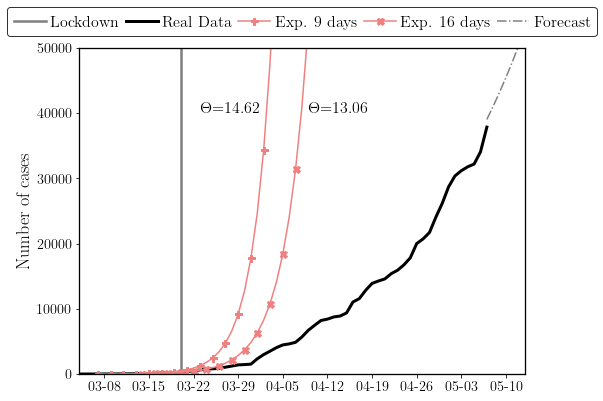

In [43]:
state='SP'
FONTSIZE=18

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

%matplotlib inline

#

df_state = utils.download_state(state=state)
df_state = df_state[df_state['cases'] != 0]
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)
X, y = utils.check_inputs(X, y)

DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.ajust_df(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
y_last_7 = forecast_last_7.values
X_last_7 = np.arange(X[-1], X[-1]+14, 1)
X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')



fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(x, np.log10(y), color='k', ls='solid', marker=MARKERS[id_state], markersize=7, label=state)

# Plot line
days = df_state.index
## format date
LOCKDOWN_DAY_IDX = days.get_loc('20/03/2020')
ax.axvline(LOCKDOWN_DAY_IDX, 0, c='gray', linewidth=2.5, label='Lockdown')

##

ax.plot(X, y, 'black', linewidth=3, markersize=7, label='Real Data')
ax.plot(X_first_7, y_first_7, c='lightcoral', marker='P', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_1))
ax.plot(X_first_14, y_first_14, c='lightcoral', marker='X', markersize=7, markevery=2, label='Exp. {} days'.format(DAYS_TO_TRAIN_2))
ax.plot(X_last_7, y_last_7, c='gray', linewidth=1.5, linestyle='-.', markersize=7, label='Forecast')

# ax.fill_between(X_first_7[:y_first_14.shape[0]].reshape(-1), y_first_7[:y_first_14.shape[0]], y_first_14, color='#539ecd')
# ax.fill_between(X_first_7.reshape(-1), y_first_7, y[:y_first_7.shape[0]].reshape(-1), color='#539ecd')

# Change xticks

# Change xticks
datetime_last_day = datetime.strptime(days[-1], '%d/%m/%Y')
dates = [datetime.strptime(x, '%d/%m/%Y') for x in days]
for i in range(1, 15):
    dates.append(datetime_last_day + timedelta(days=i))
    
dates_tormated = [x.strftime('%m-%d') for x in dates]

DAYST_TO_SHOW_IN_TICKS = 7
locs, labels = plt.xticks()
locs = [0, 11, 18, 25, 32, 39, 46, 53, 60, 67, 74]
labels = [dates_tormated[locs[i]] for i in range(len(locs))]
plt.xticks(locs, labels)

#
leg = ax.legend(fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5, handletextpad=0.3, columnspacing=0.4)
leg.get_frame().set_edgecolor('k')



ax.set_ylabel('Number of cases', fontsize=FONTSIZE)
# ax.set_xlabel('Time (days)', fontsize=FONTSIZE)
# plt.grid(ls='-.')

for ori in ax.spines:
    ax.spines[ori].set_linewidth(1.3)
    
    
# Plot arrow

# ax.arrow(12.04, 4000, 12.05, 5)
# ax.annotate("", xy=(12, 4000), xytext=(13, 5), arrowprops=dict(arrowstyle="->"))
t1 = theta(y_first_7, y[9:y_first_7.shape[0]+14])
t2 = theta(y_first_14, y[14:y_first_14.shape[0]+14])

plt.text(26, 40000, f"$\Theta$={t1}", fontsize=FONTSIZE-2)
plt.text(43, 40000, f'$\Theta$={t2}', fontsize=FONTSIZE-2)

plt.ylim(0, 50000)
plt.xlim(7, 77)
# plt.title(f'{state}', pad=50, fontsize=FONTSIZE)

plt.savefig(path.join(RESULTS_FOLDER, 'figures', '{}-comparativo-forecast.png'.format(state)), dpi=300, bbox_inches='tight')

plt.show()